## I - Imports

In [ ]:
import os

os.environ["SCIPY_ARRAY_API"] = "1" # Nécessaire pour l'import de SMOTE

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

## II - Prétraitement des données

In [2]:
os.chdir("C:/Users/thoma/Documents/Thomas - SSD/Missions_ComeUP/SamanthaGarguier")

# Chargement du dataset train
train = pd.read_csv("./Data/application_train.csv")

print(f"Shape du dataset original : {train.shape}")

print("\nDistribution de la variable cible (TARGET) :")
target_counts = train["TARGET"].value_counts()
print(target_counts)

print("\nDescription statistique du dataset original :")
print(train.describe())

Shape du dataset original : (307511, 122)

Distribution de la variable cible (TARGET) :
TARGET
0    282686
1     24825
Name: count, dtype: int64

Description statistique du dataset original :
          SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+

### Respect du RGPD :

Nos analyses ne sont fondent pas sur des *critères discriminants*.
Le **genre** en fait partie. Nous effacons donc les colonnes aux données sensibles de notre dataset.

In [3]:
cols_to_drop = ['CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE','OCCUPATION_TYPE']
train = train.drop(columns=cols_to_drop)

### Conseils du notebook :

Nous supprimons les colonnes qui possèdent trop de valeurs manquantes. En effet, remplir ces dernières ne servirait à rien il vaut mieux les retirer

In [4]:
missing_ratio = train.isnull().mean()
train = train.loc[:, missing_ratio < 0.4] 

Nous rempissons les colonnes n'ayant pas trop de valeurs manquantes. Le but est de remplacer les **valeurs vide** par **la valeur la plus commune**. Pour cela nous allons séparer les *valeurs numériques* des *valeurs catégorielles* et les traiter indépendamment.

In [5]:
# On remplace les valeurs vides de manière simple # [R Notebook Ref: Missing imputation simplifiée]
 
# Séparation des colonnes numériques et catégoriques
num_cols = train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = train.select_dtypes(include=["object", "category"]).columns.tolist()

# Imputation
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

train[num_cols] = num_imputer.fit_transform(train[num_cols])
train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])

Pour permettre aux modèles d'effectuer des calculs sur le dataset nous appliquons un One-Hot encoding qui va garantir la présence, uniquement, de valeurs numériques.

In [6]:
# Application d'un One-Hot encoding pour n'avoir que des valeurs numériques
train = pd.get_dummies(train)

Enfin, nous supprimons les colonnes qui trop corrélées

In [7]:
corr_matrix = train.drop(columns=["TARGET"]).corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

train = train.drop(columns=to_drop)

## III - Séparation des données 

Nous avons remarqué, en lisant les chiffre issus du **pd.describe()**, que les classes de ce dataset sont très désiquilibré (*0 : 300 000, 1 : 25 000*). Il éxiste plusieurs méthodes pour pallier à ce problème:

- **Oversampling** : qui va augmenter la classe minoritaire en créant des valeurs artificielles

- **Undersampling** : qui va réduire la classe majoritaire

- **Méthode SMOTE** : qui va aussi augmenter la classe minoritaire

A la vue d'un tel écart de valeurs, nous avons opté pour une méthode d'**undersampling**. En effet, l'*oversampling* créerai des 100 de milliers de valeurs factices, qui ont de gros risques de fausser les performances du modèles, et la *méthode SMOTE* n'a pas donné de résultats satisfaisant (tout en allongeant le temps de calcul)

In [8]:
# Séparation des features et du label
X = train.drop(columns=["TARGET"])
y = train["TARGET"]

# Séparation train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=13)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# On undersample la classe majoritaire pour le set d'entrainement
rus = RandomUnderSampler(random_state=13)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_scaled, y_train)

## IV - Entrainement des modèles

Comme mentionné dans le notebook il est préferable d'essayer plusieurs modèles et de les comparer. Nous avons opté pour les modèles **XGBoost**, **RandomForest** et **LogisticRegression**.

Pour chacun de ces modèles nous avons instancié une listes de paramètres à tester et, avec **GridSearchCV()** nous avons testé toutes les possibilités pour en retenir la meilleure.

In [9]:
model_params = {

    "XGBoost": {
        "model": xgb.XGBClassifier(eval_metric='logloss'),
        "params": {
            "n_estimators": [50, 100, 200, 300],
            "max_depth": [3, 5, 7, 10],
            "learning_rate": [0.01, 0.05, 0.08, 0.1],
            "subsample": [0.7, 0.8, 0.9, 1.0],
            "colsample_bytree": [0.6, 0.8, 0.9, 1.0]
        }
    },

    "RandomForest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100, 200, 300],
            "max_depth": [5, 10, 15, 20]
        }
    },

    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "C": [0.1, 1, 5, 10]
        }
    }
}

best_auc = 0 
best_name = ""
best_model = None

for name, mp in model_params.items():

    print(f"Recherche des hyperparamètres pour {name}...")
    
    grid = GridSearchCV(

        mp["model"],
        mp["params"],

        scoring="roc_auc",
        cv=5,

        n_jobs=-1,
        verbose=1)
    
    grid.fit(X_train_resampled, y_train_resampled)
    y_test_proba = grid.best_estimator_.predict_proba(X_test_scaled)[:, 1]
    
    auc = roc_auc_score(y_test, y_test_proba)
    
    print(f"{name} - AUC (train) : {auc:.3f}")
    print(f"Meilleurs paramètres: {grid.best_params_}\n")
    
    if auc > best_auc:

        best_auc = auc
        best_name = name
        best_model = grid.best_estimator_

print(f"Le meilleur modèle est {best_name} avec un AUC de {best_auc:.3f}")

Recherche des hyperparamètres pour XGBoost...
Fitting 5 folds for each of 1024 candidates, totalling 5120 fits
XGBoost - AUC (train) : 0.744
Meilleurs paramètres: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}

Recherche des hyperparamètres pour RandomForest...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
RandomForest - AUC (train) : 0.736
Meilleurs paramètres: {'max_depth': 20, 'n_estimators': 300}

Recherche des hyperparamètres pour LogisticRegression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
LogisticRegression - AUC (train) : 0.734
Meilleurs paramètres: {'C': 10}

Le meilleur modèle est XGBoost avec un AUC de 0.744


## V - Visualisation des résultats

Rapport de classification (ensemble d'entraînement) :

              precision    recall  f1-score   support

         0.0      0.724     0.731     0.728     17377
         1.0      0.729     0.722     0.725     17377

    accuracy                          0.727     34754
   macro avg      0.727     0.727     0.727     34754
weighted avg      0.727     0.727     0.727     34754



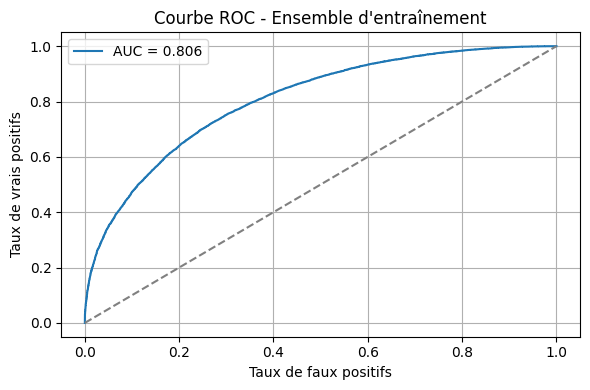

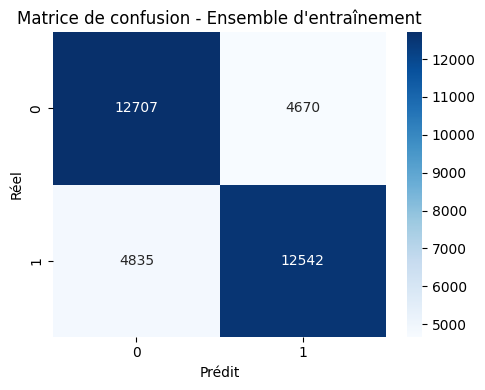

In [10]:
y_train_pred = best_model.predict(X_train_resampled)
y_train_proba = best_model.predict_proba(X_train_resampled)[:, 1]

# Affichage du rapport de classification

print("Rapport de classification (ensemble d'entraînement) :\n")
print(classification_report(y_train_resampled, y_train_pred, digits=3))

# Affichage de la courbe ROC

fpr, tpr, _ = roc_curve(y_train_resampled, y_train_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_train_resampled, y_train_proba):.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')

plt.title("Courbe ROC - Ensemble d'entraînement")
plt.ylabel("Taux de vrais positifs")
plt.xlabel("Taux de faux positifs")

plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Affichage de la matrice de confusion

cm = confusion_matrix(y_train_resampled, y_train_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion - Ensemble d'entraînement")

plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()

plt.show()

## VI - Sauvegarde du meilleur modèle

In [11]:
joblib.dump(scaler, "./Models/scaler.pkl")
joblib.dump(best_model, "./Models/model.pkl")  
joblib.dump(X_train.columns.tolist(), "./Models/features.pkl")

print("Modèle entraîné, évalué et sauvegardé.")

Modèle entraîné, évalué et sauvegardé.
